In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import PIL, urllib
import os
from PIL import Image
import pandas as pd

In [2]:
def get_diagnosis(image_name, file):

    matching_row = file[file['image_id'] == image_name.split('.')[0]]
    if not matching_row.empty:
        return matching_row.iloc[0]['dx']
    return None
    print("get diagnoses complete")

def create_image_diagnosis_dict(base_path, folders, file):
    metadata = pd.read_csv(file)

    image_diagnosis_dict = {}
    for folder in folders:
        path = base_path + folder
        for image_name in os.listdir(path):
            diagnosis = get_diagnosis(image_name, metadata)
            if diagnosis is not None:
              # Add the image name and its diagnosis to the dictionary
              image_diagnosis_dict[image_name] = diagnosis
    print("create image_diagnosis dict complete")
    return image_diagnosis_dict

In [3]:
class diagnoses(Dataset):
    CLASSES = ('nv', 'akiec', 'bcc', 'bkl', 'df', 'mel')  # Class variable

    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, label = self.data[idx]
        #print(f"Label before error: {label}")  # Debug print
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        try:
            label_idx = self.CLASSES.index(label) if isinstance(label, str) else label
        except ValueError as e:
            print(f"Error with label: {label}")
            raise e
        return image, label_idx

In [4]:
base_path = 'C:\\Users\\krish\\APS360\\PROJECT'
folders = ('\\HAM10000_images_part_1', '\\HAM10000_images_part_2')
metadata = '\\HAM10000_metadata.csv'

dataset = []

matches = create_image_diagnosis_dict(base_path, folders, base_path + metadata)

create image_diagnosis dict complete


In [5]:
def make_dataset(idx, base_path, folders, max_images=None):
    CLASSES = ('nv', 'akiec', 'bcc', 'bkl', 'df', 'mel')  # Class variable
    dataset = []
    image_count = 0
    for folder in folders:
        path = base_path + folder
        for img in sorted(os.listdir(path)):  # Optionally sort to have consistent results
            if max_images and image_count >= max_images:
                break  # Stop adding images once the maximum is reached
            image_path = os.path.join(path, img)
            label = idx.get(img)
            if label is None or label not in CLASSES:
                continue
            dataset.append((image_path, label))
            image_count += 1
        if max_images and image_count >= max_images:
            break  # Ensure to break the outer loop as well
    return dataset

In [6]:
def get_data_loader(batch_size, idx, base_path, folders):

    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    dataset = make_dataset(idx, base_path, folders, 50000)

    training_validation_ratio = 0.7
    split = int(len(dataset) * training_validation_ratio) #split at 70%

    validation_set = dataset[split:]
    train_set = dataset[:split]

    #declare pytorch dataset
    torch_train = diagnoses(train_set, transform)
    torch_validation = diagnoses(validation_set, transform)


    #create loaders
    train_loader = torch.utils.data.DataLoader(torch_train, batch_size=batch_size,
                                               num_workers=0, shuffle = True)#change num workers later
    val_loader = torch.utils.data.DataLoader(torch_validation, batch_size=batch_size,
                                              num_workers=0, shuffle = False)#change num workers later
    print("get data loader complete")

    return train_loader, val_loader

In [7]:
train_loader, val_loader = get_data_loader(64, matches, base_path, folders)

get data loader complete


In [8]:
import torchvision.models

alexnet = torchvision.models.alexnet(pretrained=True)

C:\Users\krish\anaconda3\envs\aps360\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\krish\anaconda3\envs\aps360\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
class FeatureDataset(Dataset):
    def __init__(self, feature_path, label_path):
        self.features = torch.load(feature_path)
        self.labels = torch.load(label_path)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [10]:
features_list = []
labels_list = []

for imgs, labels in train_loader:
    with torch.no_grad():
        start_time = time.time()
        features = alexnet.features(imgs)
        features_list.append(features)
        labels_list.append(labels)
    elapsed_time = time.time() - start_time
    print("elapsed time is ", elapsed_time)


features_list = [f.view(f.size(0), -1) for f in features_list]

torch.save(features_list, 'train_features.pt')
torch.save(labels_list, 'train_labels.pt')

feature_train_dataset = FeatureDataset('train_features.pt', 'train_labels.pt')

elapsed time is  0.3805990219116211
elapsed time is  0.2814507484436035
elapsed time is  0.30336666107177734
elapsed time is  0.34708404541015625
elapsed time is  0.28757452964782715
elapsed time is  0.24904227256774902
elapsed time is  0.3578073978424072
elapsed time is  0.3105900287628174
elapsed time is  0.24808692932128906
elapsed time is  0.3115978240966797
elapsed time is  0.2805652618408203
elapsed time is  0.27759456634521484
elapsed time is  0.2797262668609619
elapsed time is  0.31965208053588867
elapsed time is  0.3075685501098633
elapsed time is  0.26110148429870605
elapsed time is  0.35356783866882324
elapsed time is  0.3550984859466553
elapsed time is  0.3436746597290039
elapsed time is  0.2786886692047119
elapsed time is  0.33860063552856445
elapsed time is  0.29756832122802734
elapsed time is  0.265596866607666
elapsed time is  0.25154566764831543
elapsed time is  0.253032922744751
elapsed time is  0.2615540027618408
elapsed time is  0.24404501914978027
elapsed time is  

In [11]:
features_list = []
labels_list = []

for imgs, labels in val_loader:
    with torch.no_grad():
        start_time = time.time()
        features = alexnet.features(imgs)
        features_list.append(features)
        labels_list.append(labels)
    elapsed_time = time.time() - start_time
    print("elapsed time is ", elapsed_time)


features_list = [f.view(f.size(0), -1) for f in features_list]

torch.save(features_list, 'val_features.pt')
torch.save(labels_list, 'val_labels.pt')

feature_val_dataset = FeatureDataset('val_features.pt', 'val_labels.pt')

elapsed time is  0.28057360649108887
elapsed time is  0.2845618724822998
elapsed time is  0.28627967834472656
elapsed time is  0.2743675708770752
elapsed time is  0.3530714511871338
elapsed time is  0.3508720397949219
elapsed time is  0.35823583602905273
elapsed time is  0.32764697074890137
elapsed time is  0.32910847663879395
elapsed time is  0.34007883071899414
elapsed time is  0.3095669746398926
elapsed time is  0.328082799911499
elapsed time is  0.32266950607299805
elapsed time is  0.3733031749725342
elapsed time is  0.3290834426879883
elapsed time is  0.30562877655029297
elapsed time is  0.36016082763671875
elapsed time is  0.31982851028442383
elapsed time is  0.3137671947479248
elapsed time is  0.29971885681152344
elapsed time is  0.2952916622161865
elapsed time is  0.324512243270874
elapsed time is  0.3616764545440674
elapsed time is  0.31761908531188965
elapsed time is  0.3226606845855713
elapsed time is  0.34297657012939453
elapsed time is  0.32387614250183105
elapsed time is 

In [12]:
class SignLanguageClassifier_T(nn.Module):
    def __init__(self):
        super(SignLanguageClassifier_T, self).__init__()
        self.fc1 = nn.Linear(9216, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 120)
        self.fc4 = nn.Linear(120, 6)

    def forward(self, x):

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

print('Fully Connected Sign Language Classifier Architecture Done')

Fully Connected Sign Language Classifier Architecture Done


In [16]:
def get_accuracy(model, loader, use_cuda=True):
    """
    Computes the accuracy over the provided data loader and utilizes GPU if available and specified.

    Args:
        model: The neural network model.
        loader: DataLoader for the dataset to compute accuracy over.
        use_cuda: A boolean flag indicating whether to use CUDA (GPU) if available.

    Returns:
        The accuracy of the model on the data provided by the loader.
    """
    correct = 0
    total = 0
    if use_cuda and torch.cuda.is_available():
        model.cuda()
    else:
        model.cpu()

    with torch.no_grad():
        for imgs, labels in loader:
            if use_cuda and torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()

            output = model(imgs)

            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(labels.view_as(pred)).sum().item()
            total += imgs.shape[0]

    accuracy = correct / total
    return accuracy

In [17]:
def train(model, train_loader, val_loader, use_cuda=True, num_epochs=1):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)

    if use_cuda and torch.cuda.is_available():
        model.cuda()
    else:
        model.cpu()

    iters, losses, train_acc, val_acc = [], [], [], []

    total_start_time = time.time()

    for epoch in range(num_epochs):
        epoch_start_time = time.time()

        model.train()
        for imgs, labels in train_loader:
            if use_cuda and torch.cuda.is_available():
                imgs, labels = imgs.cuda(), labels.cuda()

            optimizer.zero_grad()
            out = model(imgs)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()

            iters.append(len(iters))
            losses.append(float(loss) / len(imgs))

        scheduler.step()

        model.eval()
        with torch.no_grad():

            train_accuracy = get_accuracy(model, train_loader, use_cuda=use_cuda)
            val_accuracy = get_accuracy(model, val_loader, use_cuda=use_cuda)
            train_acc.append(train_accuracy)
            val_acc.append(val_accuracy)

        epoch_end_time = time.time()
        print(f"Epoch {epoch+1}, Train Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}, Time: {epoch_end_time - epoch_start_time:.2f} seconds")

    total_end_time = time.time()
    total_time = total_end_time - total_start_time


    plt.figure(figsize=(10,4))
    plt.subplot(1, 2, 1)
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")

    plt.subplot(1, 2, 2)
    plt.title("Accuracy Curve")
    plt.plot(range(1, num_epochs + 1), train_acc, label="Train")
    plt.plot(range(1, num_epochs + 1), val_acc, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print(f"Total training time: {total_time:.2f} seconds")

Epoch 1, Train Accuracy: 0.7401244392996672, Validation Accuracy: 0.6836596893990546, Time: 0.76 seconds
Epoch 2, Train Accuracy: 0.7891766748661554, Validation Accuracy: 0.6890614449696151, Time: 0.66 seconds
Epoch 3, Train Accuracy: 0.8146433222399074, Validation Accuracy: 0.6799459824442944, Time: 0.62 seconds
Epoch 4, Train Accuracy: 0.8247721024453769, Validation Accuracy: 0.6444969615124916, Time: 0.63 seconds
Epoch 5, Train Accuracy: 0.7935175806684995, Validation Accuracy: 0.562120189061445, Time: 0.62 seconds
Epoch 6, Train Accuracy: 0.8982781073650702, Validation Accuracy: 0.7137069547602971, Time: 0.67 seconds
Epoch 7, Train Accuracy: 0.859788742584286, Validation Accuracy: 0.6235651586765699, Time: 0.64 seconds
Epoch 8, Train Accuracy: 0.8201418029228765, Validation Accuracy: 0.588116137744767, Time: 0.62 seconds
Epoch 9, Train Accuracy: 0.882216755896397, Validation Accuracy: 0.6360567184334909, Time: 0.61 seconds
Epoch 10, Train Accuracy: 0.8901750832006945, Validation Ac

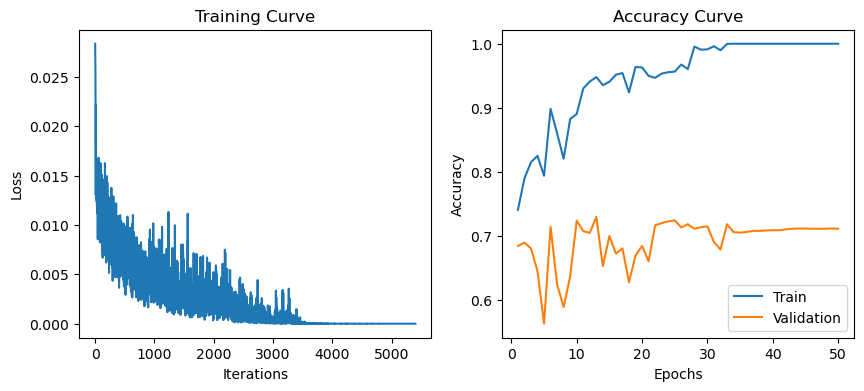

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.7106684672518568
Total training time: 33.59 seconds


In [18]:
model6 = SignLanguageClassifier_T()
train(model6, feature_train_dataset, feature_val_dataset, use_cuda=True, num_epochs=50)